## 1. Initial set-up

In [1]:
# Additional imports
import json
import os
import subprocess
import time
import math
from os import listdir

# Processing
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SearchIO import HmmerIO
from tqdm import tqdm
from xgboost import XGBClassifier

# Features
import torch
import esm

# Training
import pickle
import seaborn as sns
import phagehostlearn_utils as phlu
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
%matplotlib inline

## 2. Data processing

The data processing of PhageHostLearn consists of five consecutive steps: (1) phage gene calling with PHANOTATE, (2) phage protein embedding with bio_embeddings, (3) phage RBP detection, (4) bacterial genome processing with Kaptive and (5) processing the interaction matrix.

Expected outputs: (1) an RBPbase.csv file with detected RBPs, (2) a Locibase.json file with detected K-loci proteins, (3) a .csv file of processed interaction data.

#### 2.1 PHANOTATE

In [2]:
def phanotate_processing(phage_genomes_path, phanotate_path, output_path, add=False, test=False, num_phages=None):
    """Run PHANOTATE on each phage genome and build the gene database."""
    
    # Get the number of files in the phage genomes directory
    print(f"  Processing {len(listdir(phage_genomes_path))} phage files...")
    phage_files = listdir(phage_genomes_path)
    print(f'  Number of phage files: {len(phage_files)}')
    
    # Remove MacOS system file if present
    if '.DS_Store' in phage_files:
        phage_files.remove('.DS_Store')
    
    # If add=True, filter out already processed phages
    if add:
        rbp_base = pd.read_csv('../data/RBPbase.csv')
        phage_ids = list(set(rbp_base['phage_ID']))
        
        # Remove phages already in RBPbase from the list of phages to process
        phage_files = [x for x in phage_files if x.split('.fasta')[0] not in phage_ids]
        print(f'  Processing {len(phage_files)} more phages (add=True)')
    
    # Optionally limit to a subset of phages (for testing only)
    if num_phages is not None:
        print(f'  Processing only the first {num_phages} phages')
        phage_files = phage_files[:num_phages]
    
    # Create progress bar
    bar = tqdm(total=len(phage_files), position=0, leave=True, desc='  Processing phage genomes')
    name_list = []
    gene_list = []
    gene_ids = []

    # Process each phage file
    for file in phage_files:
        count = 1
        file_dir = phage_genomes_path + '/' + file
        
        # Construct PHANOTATE command
        raw_str = phanotate_path + ' ' + file_dir
        
        # Run PHANOTATE as a subprocess and capture output
        process = subprocess.Popen(raw_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        stdout, _ = process.communicate()
        stdout_text = stdout.decode('utf-8', errors='ignore')
        
        # Check for PHANOTATE execution errors
        if process.returncode != 0:
            raise RuntimeError(
                f"PHANOTATE command failed for {file_dir} with exit code {process.returncode}. "
                f"Command output:\n{stdout_text}"
            )
        
        # Skip the PHANOTATE header (first 2 lines)
        std_splits = stdout.split(sep=b'\n')[2:]
        
        # If no ORFs found, raise error (Open Reading Frame). It's the portions of the sequences.
        if not any(split.strip() for split in std_splits):
            raise ValueError(
                f"PHANOTATE did not return ORF predictions for {file_dir}. "
                f"Command output:\n{stdout_text}"
            )
        
        # Write table to a temporary TSV file, clean up commas if present
        temp_tab_path = os.path.join('../data/phage_results.tsv')
        with open(temp_tab_path, 'wb') as temp_tab:
            for split in std_splits:
                split = split.replace(b',', b'')
                temp_tab.write(split + b'\n')
        
        # Load PHANOTATE result as a pandas DataFrame
        try:
            results_orfs = pd.read_csv(temp_tab_path, sep='\t', lineterminator='\n', index_col=False)
        except pd.errors.EmptyDataError as exc:
            with open(temp_tab_path, 'r', encoding='utf-8', errors='ignore') as temp_in:
                temp_preview = temp_in.read()
            raise ValueError(
                f"PHANOTATE output for {file_dir} produced an empty or invalid TSV file.\n"
                f"Command output:\n{stdout_text}\n"
                f"Temporary TSV content:\n{temp_preview}"
            ) from exc
        
        # Parse phage file name (without .fasta extension)
        name = file.split('.fasta')[0]
        
        # Fetch full nucleotide sequence of the phage
        sequence = str(SeqIO.read(file_dir, 'fasta').seq)
        
        # Iterate over ORFs
        for j, strand in enumerate(results_orfs['FRAME']):
            start = results_orfs['#START'][j]
            stop = results_orfs['STOP'][j]
            if strand == '+':
        
                # Forward strand: take subsequence from start to stop (1-based, inclusive)
                gene = sequence[start - 1:stop]
            else:
        
                # Reverse strand: take subsequence, then reverse complement
                sequence_part = sequence[stop - 1:start]
                gene = str(Seq(sequence_part).reverse_complement())
            name_list.append(name)
            gene_list.append(gene)
            gene_ids.append(name + '_gp' + str(count))
            count += 1
        bar.update(1)
    bar.close()

    # Clean up temporary file if not in test mode
    if not test and os.path.exists('../data/phage_results.tsv'):
        os.remove('../data/phage_results.tsv')

    # Build DataFrame of all predicted gene sequences
    genebase_df = pd.DataFrame(list(zip(name_list, gene_ids, gene_list)), columns=['phage_ID', 'gene_ID', 'gene_sequence'])
    
    # If add=True, concatenate with previous gene database
    if add:
        old_genebase_df = pd.read_csv(output_path)
        genebase_df = pd.concat([old_genebase_df, genebase_df], axis=0)
    
    # Save to CSV
    genebase_df.to_csv(output_path, index=False)
    print(f'  Completed PHANOTATE - Number of phage genes: {len(genebase_df)}')
    return genebase_df

In [3]:
print("\n[STEP 2.1] Running PHANOTATE on phage genomes...")
phage_genomes_path = '../data/phages_genomes'
phanotate_path = '/Users/eliottvalette/Documents/Clones/PhageHostLearn/.venv/bin/phanotate.py'
output_path = '../data/phage_genes.csv'
genebase_df = phanotate_processing(phage_genomes_path, phanotate_path, output_path, num_phages=2)
genebase_df.head()


[STEP 2.1] Running PHANOTATE on phage genomes...
  Processing 105 phage files...
  Number of phage files: 105
  Processing only the first 2 phages


  Processing phage genomes: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it]

  Completed PHANOTATE - Number of phage genes: 145


,phage_ID,gene_ID,gene_sequence
0,A1a,A1a_gp1,TTAGACGCTGTGAACCTGACGTTAGAAGCCCTGGGGGAGTCTCGCG...
1,A1a,A1a_gp2,ATGGCGCAATCATTAGAAGGCACCATTCAGAGTCTGCTCCAGGGCG...
2,A1a,A1a_gp3,ATGGCTATGTGGTGGGCTGTCGCCGCCCTGGCAGGCTCTAAGCTGC...
3,A1a,A1a_gp4,ATGCCTGTAATTCAACCCAACCGACAGGGTCTAAATATCGGCGGCG...
4,A1a,A1a_gp5,ATGGCTCAGTTTCTGAACCAAGAACCGAATCCACAGGAAAAGGATT...


#### 2.2 Protein embeddings

In [ ]:
def compute_protein_embeddings(genebase_path, add=False, num_genes=None):
    """
    Compute protein embeddings for phage gene sequences using ProtTransBertBFD.

    Parameters:
    - data_suffix (str): Optional string to add as suffix to the output embeddings filename.
    - add (bool): If True, only compute embeddings for new genes and add to existing file.
    - num_genes (int or None): If set, only process the first num_genes genes in phage_genes.csv.

    Returns:
    - None. Embedding data is saved as a CSV file at the computed path.
    """

    # Load phage gene base table
    genebase = pd.read_csv(genebase_path)
    
    # If num_genes is set, use only the first num_genes genes for embedding
    if num_genes is not None:
        print(f'  Processing only the first {num_genes} phage genes')
        genebase = genebase.head(num_genes)
    print(f'  Number of phage genes: {len(genebase)}')
    
    # Import the embedding model from bio_embeddings
    print('  Importing ProtTransBertBFDEmbedder...')
    from bio_embeddings.embed import ProtTransBertBFDEmbedder
    print('  Import successful')
    
    # Initialize the embedder timing the operation
    time_start = time.time()
    embedder = ProtTransBertBFDEmbedder()
    time_end = time.time()
    print(f'  Time taken to initialize embedder: {time_end - time_start:.2f} seconds')
    print('  Embedder initialized')
    
    # If adding new sequences to existing embeddings
    if add:
        print('  Adding new protein embeddings')
        
        # Load the existing embeddings DataFrame (must exist when add=True)
        old_embeddings_df = pd.read_csv('../data/phage_protein_embeddings.csv')
        protein_ids = list(old_embeddings_df['ID'])
        sequences = []
        names = []
        
        # For each gene, if it is not already embedded, add it to the embedding queue
        for i, sequence in enumerate(genebase['gene_sequence']):
            if genebase['gene_ID'][i] not in protein_ids:
                # Translate DNA to protein sequence and strip last stop codon (*)
                sequences.append(str(Seq(sequence).translate())[:-1])
                names.append(genebase['gene_ID'][i])
    
    else:
        print('  Computing protein embeddings for all phage genes')
        
        # Take all gene IDs as names
        names = list(genebase['gene_ID'])
        print(f'  Number of protein sequences to embed: {len(names)}')
        
        # Translate all DNA sequences to protein sequences, minus last stop codon
        sequences = [str(Seq(sequence).translate())[:-1] for sequence in genebase['gene_sequence']]

    print(f'  Number of protein sequences to embed: {len(sequences)}')
    protein_embeddings = []
    
    # Progress bar for embedding computation
    progress_bar = tqdm(sequences, desc='  Computing protein embeddings', unit='protein')
    for protein_sequence in progress_bar:
        
        # Compute the embedding for each protein sequence and reduce to a fixed-size vector
        reduced_embedding = embedder.reduce_per_protein(embedder.embed(protein_sequence))
        protein_embeddings.append(reduced_embedding)
    
    # Combine names and embeddings into a DataFrame
    embeddings_df = pd.concat([pd.DataFrame({'ID': names}), pd.DataFrame(protein_embeddings)], axis=1)
    
    # If add = True, vertically stack the old and new DataFrames (NP vstack ensures correct shape)
    if add:
        embeddings_df = pd.DataFrame(np.vstack([old_embeddings_df, embeddings_df]), columns=old_embeddings_df.columns)
    
    # Save embedding DataFrame to CSV file
    embeddings_df.to_csv('../data/phage_protein_embeddings.csv', index=False)
    print(f'  Protein embeddings saved to: ../data/phage_protein_embeddings.csv')
    return embeddings_df


In [5]:
rbpbase_path = '../data/RBPbase.csv'

if os.path.exists(rbpbase_path) :
    print("\n[STEP 2.2] Computing protein embeddings with ProtTransBertBFD...")
    print("  RBPbase already exists - skipping protein embeddings computation.")
    embeddings_df = pd.read_csv(rbpbase_path)
else :
    embeddings_df = compute_protein_embeddings(rbpbase_path, num_genes=5)

embeddings_df.head()


[STEP 2.2] Computing protein embeddings with ProtTransBertBFD...
  RBPbase already exists - skipping protein embeddings computation.


,phage_ID,protein_ID,protein_sequence,dna_sequence,xgb_score
0,A1a,A1a_gp2,MAQSLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRR...,ATGGCGCAATCATTAGAAGGCACCATTCAGAGTCTGCTCCAGGGCG...,0.557746
1,A1a,A1a_gp6,MAYSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSS...,ATGGCATACAGCTGGCAAGAGTCGGTAAAGCCTGCAGGTACACAGG...,0.998525
2,A1a,A1a_gp14,MALVNLVTVNPRDLTHVQSYAELTTTVPKAAGERIVLLQYAPGLAP...,ATGGCTCTTGTTAACCTGGTTACAGTAAACCCAAGAGATTTAACGC...,0.999766
3,K52PH129C1,K52PH129C1_gp64,MAADGTVTGTGTKWQSSLSLIRPGATIMFLSSPIQMAVVNKVVSDT...,ATGGCCGCAGACGGAACCGTTACCGGGACTGGCACAAAATGGCAAT...,0.997867
4,K52PH129C1,K52PH129C1_gp67,MTNIKARKGGSSKPRTPVEMPDNLISKDKIKLLLAVSDGEVVNDFS...,ATGACTAATATCAAGGCCCGCAAGGGTGGTTCAAGCAAGCCACGTA...,0.983808


#### 2.3 PhageRBPdetect

In [ ]:
def hmmpress_python(hmm_path, pfam_file):
    """Press a profiles database, necessary to do scanning."""
    # Create command to change directory and run hmmpress on the Pfam file
    cd_str = 'cd ' + hmm_path  # Change to the HMMER directory
    press_str = 'hmmpress ' + pfam_file  # Command to press the HMM database
    command = cd_str + '; ' + press_str  # Combine commands with ';'
    
    # Run the hmmpress command in a subprocess
    press_process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    press_out, press_err = press_process.communicate()  # Capture output and error
    return press_out, press_err  # Return the output and error


def single_hmmscan_python(hmm_path, pfam_file, fasta_file):
    """Run hmmscan for a given FASTA file of one (or multiple) sequences."""
    # Change current directory to the HMMER directory
    cd_str = 'cd ' + hmm_path
    cd_process = subprocess.Popen(cd_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    cd_process.communicate()
    
    # Run hmmscan on the fasta_file using the pfam_file database, save results to text file
    scan_str = 'hmmscan ' + pfam_file + ' ' + fasta_file + ' > hmmscan_out.txt'
    scan_process = subprocess.Popen(scan_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    scan_process.communicate()
    
    # Parse results
    with open('hmmscan_out.txt') as results_handle:
        scan_res = HmmerIO.Hmmer3TextParser(results_handle)
    
    # Remove output file
    os.remove('hmmscan_out.txt')
    return scan_res  # Return parsed scan results


def hmmscan_python(hmm_path, pfam_file, sequences_file, threshold=18):
    """Scan sequences for domains using hmmscan."""
    domains = []  # List to store domain names
    scores = []   # List to store bitscores
    biases = []   # List to store bias scores
    ranges = []   # List to store alignment ranges
    
    # Iterate over each sequence in the fasta file
    for sequence in SeqIO.parse(sequences_file, 'fasta'):
        
        # Write single sequence to a temporary fasta file
        with open('single_sequence.fasta', 'w') as temp_fasta:
            temp_fasta.write('>' + sequence.id + '\n' + str(sequence.seq) + '\n')

        # Run hmmscan on the single sequence
        scan_res = single_hmmscan_python(hmm_path, pfam_file, 'single_sequence.fasta')
        
        # Iterate over results lines and hits
        for line in scan_res:
            try:
                for hit in line.hits:
                    hsp = hit._items[0]  # Take the first HSP (high scoring pair)
                    aln_start = hsp.query_range[0]
                    aln_stop = hsp.query_range[1]
                    
                    # Only add unique domains with score >= threshold
                    if (hit.bitscore >= threshold) and (hit.id not in domains):
                        domains.append(hit.id)
                        scores.append(hit.bitscore)
                        biases.append(hit.bias)
                        ranges.append((aln_start, aln_stop))
            
            except IndexError:
                # If there are no hits, skip
                pass
    
    # Remove the temporary fasta file after processing
    os.remove('single_sequence.fasta')
    return domains, scores, biases, ranges  # Return results


def gene_domain_scan(hmmpath, pfam_file, gene_hits, threshold=18):
    """Run hmmscan on translated gene hits."""
    # Write each gene hit (translated) to a temporary protein fasta file
    with open('protein_hits.fasta', 'w') as hits_fasta:
        for i, gene_hit in enumerate(gene_hits):
            protein_sequence = str(Seq(gene_hit).translate())[:-1]
            hits_fasta.write('>' + str(i) + '_proteindomain_hit\n' + protein_sequence + '\n')
    
    # Scan the protein fasta file with hmmscan
    domains, scores, biases, ranges = hmmscan_python(hmmpath, pfam_file, 'protein_hits.fasta', threshold)
    
    # Remove the temporary fasta file
    os.remove('protein_hits.fasta')
    return domains, scores, biases, ranges  # Return scan results


def phageRBPdetect(pfam_path, hmmer_path, xgb_path, gene_embeddings_path):
    """Detect receptor-binding proteins using PhageRBPdetect."""
    print(f"  Loading genebase from {'../data/phage_genes.csv'}")
    genebase = pd.read_csv('../data/phage_genes.csv')  # Load phage genes from CSV
    
    # List of all possible functional blocks/domains of interest
    new_blocks = ['Phage_T7_tail', 'Tail_spike_N', 'Prophage_tail', 'BppU_N', 'Mtd_N', 'Head_binding', 'DUF3751',
                  'End_N_terminal', 'phage_tail_N', 'Prophage_tailD1', 'DUF2163', 'Phage_fiber_2', 'unknown_N0',
                  'unknown_N1', 'unknown_N2', 'unknown_N3', 'unknown_N4', 'unknown_N6', 'unknown_N10', 'unknown_N11',
                  'unknown_N12', 'unknown_N13', 'unknown_N17', 'unknown_N19', 'unknown_N23', 'unknown_N24',
                  'unknown_N26', 'unknown_N29', 'unknown_N36', 'unknown_N45', 'unknown_N48', 'unknown_N49',
                  'unknown_N53', 'unknown_N57', 'unknown_N60', 'unknown_N61', 'unknown_N65', 'unknown_N73',
                  'unknown_N82', 'unknown_N83', 'unknown_N101', 'unknown_N114', 'unknown_N119', 'unknown_N122',
                  'unknown_N163', 'unknown_N174', 'unknown_N192', 'unknown_N200', 'unknown_N206', 'unknown_N208',
                  'Lipase_GDSL_2', 'Pectate_lyase_3', 'gp37_C', 'Beta_helix', 'Gp58', 'End_beta_propel',
                  'End_tail_spike', 'End_beta_barrel', 'PhageP22-tail', 'Phage_spike_2', 'gp12-short_mid', 'Collar',
                  'unknown_C2', 'unknown_C3', 'unknown_C8', 'unknown_C15', 'unknown_C35', 'unknown_C54', 'unknown_C76',
                  'unknown_C100', 'unknown_C105', 'unknown_C112', 'unknown_C123', 'unknown_C179', 'unknown_C201',
                  'unknown_C203', 'unknown_C228', 'unknown_C234', 'unknown_C242', 'unknown_C258', 'unknown_C262',
                  'unknown_C267', 'unknown_C268', 'unknown_C274', 'unknown_C286', 'unknown_C292', 'unknown_C294',
                  'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672']

    print("  Pressing HMM database...")
    
    # Make sure the profile HMM database is indexed for hmmscan
    output, err = hmmpress_python(hmmer_path, pfam_path)
    print(output.decode('utf-8', errors='ignore'))

    phage_genes = genebase['gene_sequence']  # Get gene sequences
    
    # Initialize domain score matrix with zeros
    hmm_scores = {item: [0] * len(phage_genes) for item in new_blocks}
    
    # Progress bar for scanning all genes
    bar = tqdm(total=len(phage_genes), position=0, leave=True, desc='  Scanning phage genes')
    for i, sequence in enumerate(phage_genes):
        
        # For each gene, scan for domains
        hits, scores, biases, ranges = gene_domain_scan(hmmer_path, pfam_path, [sequence])
        
        # Save scores for detected domains
        for j, dom in enumerate(hits):
            hmm_scores[dom][i] = scores[j]
        bar.update(1)
    bar.close()

    print("  Loading embeddings and computing features...")
    embeddings_df = pd.read_csv(gene_embeddings_path)  # Load protein embeddings for each gene
    embeddings = np.asarray(embeddings_df.iloc[:, 1:])  # Get the embedding vectors (without gene_ID)
    hmm_scores_array = np.asarray(pd.DataFrame(hmm_scores))  # Convert domain scores to array
    
    # Concatenate features: embedding + domain scores
    features = np.concatenate((embeddings, hmm_scores_array), axis=1)

    print("  Loading XGBoost model for RBP detection...")
    xgb_saved = XGBClassifier()  # Initialize XGBoost classifier
    xgb_saved.load_model(xgb_path)  # Load pretrained model from disk

    print("  Making predictions...")
    score_xgb = xgb_saved.predict_proba(features)[:, 1]  # Get probability for class 1 (RBP)
    preds_xgb = (score_xgb > 0.5) * 1  # Apply threshold for classification

    # Prepare results for output
    rbp_base = {'phage_ID': [], 'protein_ID': [], 'protein_sequence': [], 'dna_sequence': [], 'xgb_score': []}
    
    # Filter genes predicted as RBP (pred = 1)
    for i, dna_sequence in enumerate(genebase['gene_sequence']):
        if preds_xgb[i] == 1:
            rbp_base['phage_ID'].append(genebase['phage_ID'][i])
            rbp_base['protein_ID'].append(genebase['gene_ID'][i])
            rbp_base['protein_sequence'].append(str(Seq(dna_sequence).translate())[:-1])  # Translate DNA to protein (remove stop)
            rbp_base['dna_sequence'].append(dna_sequence)
            rbp_base['xgb_score'].append(score_xgb[i])
    rbp_base_df = pd.DataFrame(rbp_base)
    
    # Remove short/long proteins (<200 or >1500 aa)
    to_delete = [i for i, protein_seq in enumerate(rbp_base_df['protein_sequence']) if (len(protein_seq) < 200 or len(protein_seq) > 1500)]
    rbp_base_df = rbp_base_df.drop(to_delete).reset_index(drop=True)
    
    # Save results to CSV
    rbp_base_df.to_csv('../data/RBPbase.csv', index=False)
    print(f"  RBP detection completed - Found {len(rbp_base_df)} RBPs")
    return rbp_base_df

In [7]:
# 2.3 PhageRBPdetect
print("\n[STEP 2.3] Running PhageRBPdetect...")

# Check if RBPbase already exists
rbpbase_path = '../data/RBPbase.csv'
rbpbase_path = os.path.join(rbpbase_path)

if os.path.exists(rbpbase_path) :
    print("  RBPbase already exists - skipping PhageRBPdetect.")
    rbp_base_df = pd.read_csv('../data/RBPbase.csv')
else:
    root_path = '../'
    
    pfam_path = os.path.join(root_path, 'RBPdetect_phageRBPs.hmm')
    if not os.path.exists(pfam_path):
        pfam_path = os.path.join(root_path, 'code', 'RBPdetect_phageRBPs.hmm')

    hmmer_path = os.path.join(root_path, 'hmmer-3.4')
    if not os.path.exists(hmmer_path):
        raise FileNotFoundError(f"HMMER directory not found at {hmmer_path}")

    xgb_path = os.path.join(root_path, 'RBPdetect_xgb_hmm.json')
    if not os.path.exists(xgb_path):
        xgb_path = os.path.join(root_path, 'code', 'RBPdetect_xgb_hmm.json')

    gene_embeddings_path = os.path.join(root_path, 'phage_protein_embeddings.csv')
    if not os.path.exists(gene_embeddings_path):
        raise FileNotFoundError(
            f"Protein embeddings file not found at {gene_embeddings_path}. "
            f"Please compute protein embeddings first or ensure the file exists."
        )

    
    rbp_base_df = phageRBPdetect(pfam_path, hmmer_path, xgb_path, gene_embeddings_path)

rbp_base_df.head()


[STEP 2.3] Running PhageRBPdetect...
  RBPbase already exists - skipping PhageRBPdetect.


,phage_ID,protein_ID,protein_sequence,dna_sequence,xgb_score
0,A1a,A1a_gp2,MAQSLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRR...,ATGGCGCAATCATTAGAAGGCACCATTCAGAGTCTGCTCCAGGGCG...,0.557746
1,A1a,A1a_gp6,MAYSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSS...,ATGGCATACAGCTGGCAAGAGTCGGTAAAGCCTGCAGGTACACAGG...,0.998525
2,A1a,A1a_gp14,MALVNLVTVNPRDLTHVQSYAELTTTVPKAAGERIVLLQYAPGLAP...,ATGGCTCTTGTTAACCTGGTTACAGTAAACCCAAGAGATTTAACGC...,0.999766
3,K52PH129C1,K52PH129C1_gp64,MAADGTVTGTGTKWQSSLSLIRPGATIMFLSSPIQMAVVNKVVSDT...,ATGGCCGCAGACGGAACCGTTACCGGGACTGGCACAAAATGGCAAT...,0.997867
4,K52PH129C1,K52PH129C1_gp67,MTNIKARKGGSSKPRTPVEMPDNLISKDKIKLLLAVSDGEVVNDFS...,ATGACTAATATCAAGGCCCGCAAGGGTGGTTCAAGCAAGCCACGTA...,0.983808


#### 2.4 Kaptive

In [ ]:
def kaptive_python(database_path, file_path, output_dir='../data'):
    # Wrapper for Kaptive CLI
    command = (f"python kaptive.py -a {file_path} -k {database_path} -o {output_dir}/ --no_table")
    ssprocess = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, _ = ssprocess.communicate()
    if ssprocess.returncode != 0:
        raise RuntimeError(f"Kaptive failed for {file_path}.\nCmd: {command}\nOutput:\n{stdout.decode(errors='ignore')}")
    return

def process_bacterial_genomes(bact_genomes_path, database_path, output_dir = '../data', add = False, num_phages = None):
    """
    Run Kaptive on a set of bacterial genome FASTA files and build:
      - serotypes.csv  (one serotype per accession)
      - Locibase.json  (list of locus protein sequences per accession)
      - kaptive_results_all_loci.fasta (concatenated locus sequences)
    """

    # List FASTA files deterministically to get reproducible subsets
    fastas = sorted(listdir(bact_genomes_path))
    
    # Keep only the files that ends with .fasta
    fastas = [f for f in fastas if f.endswith('.fasta')]

    # If we're appending, filter out accessions already processed
    if add:
        locibase_path = os.path.join(output_dir, 'Locibase.json')
        if not os.path.exists(locibase_path):
            raise FileNotFoundError(
                f"add=True but {locibase_path} does not exist. Run once with add=False first."
            )
        with open(locibase_path) as dict_file:
            old_locibase = json.load(dict_file)
        already_done = set(old_locibase.keys())
        fastas = [x for x in fastas if x.split('.fasta')[0] not in already_done]
        print(f'  Processing {len(fastas)} more bacteria (add=True)')

    # Optionally limit the run to a subset (after filtering)
    if num_phages is not None:
        fastas = fastas[:num_phages]
        print(f'  Limiting to the first {num_phages} genomes')

    accessions = [file.split('.fasta')[0] for file in fastas]
    serotypes = []
    loci_results = {}

    # Progress bar over the selected genomes
    pbar = tqdm(total=len(fastas), desc='  Processing bacterial genomes')

    # Concatenated locus sequences will be saved here
    big_fasta_path = os.path.join(output_dir, 'kaptive_results_all_loci.fasta')
    with open(big_fasta_path, 'w') as big_fasta:
        for i, file in enumerate(fastas):
            file_path = os.path.join(bact_genomes_path, file)

            # Run Kaptive for this genome
            kaptive_python(database_path, file_path, output_dir=output_dir)

            # Kaptive should produce these two artifacts in output_dir for each input:
            #  - kaptive_results.json (structured summary)
            #  - kaptive_results_<input_filename> (FASTA of locus sequences)
            json_path = os.path.join(output_dir, 'kaptive_results.json')
            locus_fasta = os.path.join(output_dir, f'kaptive_results_{file}')

            if not os.path.exists(json_path):
                raise FileNotFoundError(
                    f"Expected Kaptive output not found: {json_path}"
                )
            if not os.path.exists(locus_fasta):
                raise FileNotFoundError(
                    f"Expected Kaptive locus FASTA not found: {locus_fasta}"
                )

            # Parse JSON: serotype and per-gene protein sequences
            with open(json_path, 'r') as jf:
                results = json.load(jf)

            # Serotype of the best locus match
            serotypes.append(results[0]['Best match']['Type'])

            # Extract protein sequences; prefer tblastn result over reference when available
            for gene in results[0]['Locus genes']:
                try:
                    protein = gene['tblastn result']['Protein sequence']
                    protein = protein.replace('-', '').replace('*', '')
                except KeyError:
                    protein = gene['Reference']['Protein sequence']
                loci_results.setdefault(accessions[i], []).append(protein[:-1])  # trim trailing stop if any

            # Concatenate all locus records for this genome into one long sequence
            loci_sequence = ''
            for record in SeqIO.parse(locus_fasta, 'fasta'):
                loci_sequence += str(record.seq)
            big_fasta.write(f'>{accessions[i]}\n{loci_sequence}\n')

            # Clean up intermediates produced by BLAST and Kaptive
            for extension in ['.ndb', '.not', '.ntf', '.nto']:
                tmp_path = file_path + extension
                if os.path.exists(tmp_path):
                    os.remove(tmp_path)
            if os.path.exists(json_path):
                os.remove(json_path)
            if os.path.exists(locus_fasta):
                os.remove(locus_fasta)

            pbar.update(1)
    pbar.close()

    # Build/update serotype table
    sero_df = pd.DataFrame(serotypes, columns=['sero'])
    if add:
        # Merge with existing results
        loci_results = {**old_locibase, **loci_results}
        sero_csv = os.path.join(output_dir, 'serotypes.csv')
        if os.path.exists(sero_csv):
            old_seros = pd.read_csv(sero_csv)
            sero_df = pd.concat([old_seros, sero_df], axis=0)

    # Persist final artifacts
    sero_df.to_csv(os.path.join(output_dir, 'serotypes.csv'), index=False)
    with open(os.path.join(output_dir, 'Locibase.json'), 'w') as dict_file:
        json.dump(loci_results, dict_file)

    print(f"  Kaptive processing completed - Processed {len(accessions)} bacteria")
    return sero_df


#### 2.5 Process the interaction matrix

In [9]:
print("\n[STEP 2.4] Running Kaptive on bacterial genomes...")

sero_df = process_bacterial_genomes(
    bact_genomes_path='../data/klebsiella_genomes/fasta_files',
    database_path='../data/Klebsiella_k_locus_primary_reference.gbk',
    output_dir='../data',
    add=False,
    num_phages=2
)

sero_df.head()


[STEP 2.4] Running Kaptive on bacterial genomes...
  Limiting to the first 2 genomes


  Processing bacterial genomes: 100%|██████████| 2/2 [00:34<00:00, 17.31s/it]

  Kaptive processing completed - Processed 2 bacteria


,sero
0,unknown (KL151)
1,K22


## 3. Feature construction

Starts from the RBPbase.csv and the Locibase.json files that should be stored in the general_path. If you wish to reproduce our analyses, you can download these files from our [Zenodo repository](https://doi.org/10.5281/zenodo.8095914).

Expected outputs: (1) a .csv file with RBP embeddings, (2) a .csv file with loci embeddings. The last function outputs the following Python objects: ESM-2 feature matrix, labels, groups_loci and groups_phage (for evaluation). If the ESM-2 embeddings take too long, you might opt to do this step in the cloud or on a high-performance computer.

If you're retraining a model with the same data but new validated interactions, you can simply run the `construct_feature_matrices` function to construct updated feature matrices and labels and train models anew.

In [10]:

def compute_esm2_embeddings_rbp(add=False):
    """
    This function computes ESM-2 embeddings for the RBPs, from the RBPbase.csv file.

    INPUTS:
    - general path to the project data folder
    - data suffix to optionally add to the saved file name (default='')
    OUTPUT: esm2_embeddings_rbp.csv
    """
    # load the ESM2 model
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()  # disables dropout for deterministic results

    # get the correct data to embed
    RBPbase = pd.read_csv('../data/RBPbase.csv')
    if add == True:
        old_embeddings_df = pd.read_csv('../data/esm2_embeddings_rbp.csv')
        protein_ids = list(set(old_embeddings_df['protein_ID']))
        to_delete = [i for i, prot_id in enumerate(RBPbase['protein_ID']) if prot_id in protein_ids]
        RBPbase = RBPbase.drop(to_delete)
        RBPbase = RBPbase.reset_index(drop=True)
        print('Processing ', len(RBPbase['protein_sequence']), ' more sequences (add=True)')

    # loop over data and embed (batch size = 1)
    bar = tqdm(total=len(RBPbase['protein_sequence']), position=0, leave=True)
    sequence_representations = []
    for i, sequence in enumerate(RBPbase['protein_sequence']):
        data = [(RBPbase['protein_ID'][i], sequence)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)
        token_representations = results["representations"][33]
        for j, (_, seq) in enumerate(data):
            sequence_representations.append(token_representations[j, 1 : len(seq) + 1].mean(0))
        bar.update(1)
    bar.close()

    # save results
    phage_ids = RBPbase['phage_ID']
    ids = RBPbase['protein_ID']
    embeddings_df = pd.concat([pd.DataFrame({'phage_ID':phage_ids}), pd.DataFrame({'protein_ID':ids}), pd.DataFrame(sequence_representations).astype('float')], axis=1)
    if add == True:
        embeddings_df = pd.DataFrame(np.vstack([old_embeddings_df, embeddings_df]), columns=old_embeddings_df.columns)
    embeddings_df.to_csv('../data/esm2_embeddings_rbp.csv', index=False)
    return embeddings_df


In [11]:
esm2_embeddings_rbp_df_path = '../data/esm2_embeddings_rbp.csv'

if os.path.exists(esm2_embeddings_rbp_df_path) :
    print("\n[STEP 3.1] Computing ESM 2 embeddings RBP...")
    print("  esm2_embeddings_rbp_df already exists - skipping ...")
    esm2_embeddings_rbp_df = pd.read_csv(esm2_embeddings_rbp_df_path)
else :
    esm2_embeddings_rbp_df = compute_esm2_embeddings_rbp()

esm2_embeddings_rbp_df.head()


[STEP 3.1] Computing ESM 2 embeddings RBP...
  esm2_embeddings_rbp_df already exists - skipping ...


,phage_ID,protein_ID,0,1,2,3,4,5,6,7,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,A1a,A1a_gp2,0.015170,0.006707,-0.039550,0.052477,-0.114898,0.008859,0.033923,-0.197453,...,0.032059,0.010176,0.064513,0.031362,-0.000518,-0.048467,0.084286,-0.046626,-0.062618,0.088810
1,A1a,A1a_gp6,0.011355,-0.017203,-0.057444,0.013485,-0.050032,0.011962,0.003322,-0.130226,...,0.011854,-0.030206,0.020036,0.000723,-0.007055,-0.069166,0.116961,-0.094689,-0.002961,0.126417
2,A1a,A1a_gp14,0.027346,0.047213,-0.014247,0.001598,-0.096447,0.009574,0.008162,-0.067538,...,0.003859,0.005736,0.100554,0.006659,0.023383,0.006956,0.086507,-0.072494,0.037751,0.068634
3,K52PH129C1,K52PH129C1_gp64,0.025134,-0.006678,-0.031098,0.065587,-0.102079,-0.001362,0.035219,-0.156839,...,-0.034139,-0.070584,0.021160,0.067449,0.045207,-0.084227,0.053909,-0.170797,0.032245,0.138693
4,K52PH129C1,K52PH129C1_gp67,0.003330,-0.032105,0.013802,0.001294,-0.076777,-0.000821,0.034497,-0.169872,...,0.020101,-0.082014,-0.056513,-0.038780,0.020612,-0.073250,0.088379,-0.105585,-0.054324,0.101468


In [12]:
def compute_esm2_embeddings_loci(add=False):
    """
    This function computes ESM-2 embeddings for the loci proteins, from the Locibase.json file.

    INPUTS:
    - general path to the project data folder
    - data suffix to optionally add to the saved file name (default='')
    OUTPUT: esm2_embeddings_loci.csv
    """
    # Load ESM-2 model
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()  # disables dropout for deterministic results

    # Load json file
    dict_file = open('../data/Locibase.json')
    loci_dict = json.load(dict_file)
    if add == True:
        old_embeddings_df = pd.read_csv('../data/esm2_embeddings_loci.csv')
        old_accessions = list(set(old_embeddings_df['accession']))
        for key in loci_dict.keys():
            if key in old_accessions:
                del loci_dict[key]
        print('Processing ', len(loci_dict.keys()), ' more bacteria (add=True)')

    # loop over data and embed (batch size = 1)
    loci_representations = []
    for key in tqdm(loci_dict.keys()):
        embeddings = []
        for sequence in loci_dict[key]:
            data = [(key, sequence)]
            batch_labels, batch_strs, batch_tokens = batch_converter(data)
            with torch.no_grad():
                results = model(batch_tokens, repr_layers=[33], return_contacts=True)
            token_representations = results["representations"][33]
            for i, (_, seq) in enumerate(data):
                embeddings.append(token_representations[i, 1 : len(seq) + 1].mean(0))
        locus_embedding = np.mean(np.vstack(embeddings), axis=0)
        loci_representations.append(locus_embedding)

    # save results
    embeddings_df = pd.concat([pd.DataFrame({'accession':list(loci_dict.keys())}), pd.DataFrame(loci_representations)], axis=1)
    if add == True:
        embeddings_df = pd.DataFrame(np.vstack([old_embeddings_df, embeddings_df]), columns=old_embeddings_df.columns)
    embeddings_df.to_csv('../data/esm2_embeddings_loci.csv', index=False)
    return embeddings_df

In [13]:
esm2_embeddings_loci_df_path = '../data/esm2_embeddings_loci.csv'

if os.path.exists(esm2_embeddings_loci_df_path) :
    print("\n[STEP 3.2] Computing ESM 2 embeddings RBP...")
    print("  esm2_embeddings_loci_df already exists - skipping ...")
    esm2_embeddings_loci_df = pd.read_csv(esm2_embeddings_loci_df_path)
else :
    esm2_embeddings_loci_df = compute_esm2_embeddings_loci()

esm2_embeddings_loci_df.head()


[STEP 3.2] Computing ESM 2 embeddings RBP...
  esm2_embeddings_loci_df already exists - skipping ...


,accession,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,KP_HGUA02_071,0.004189,-0.050828,-0.007553,0.050254,-0.082988,-0.015299,0.020652,-0.055177,-0.019494,...,0.034147,-0.070730,-0.060442,-0.007549,-0.024045,0.035140,0.068791,-0.111055,-0.018542,0.063740
1,205KP-HG,0.004829,-0.046680,-0.011637,0.054311,-0.079746,-0.018294,0.007261,-0.056263,-0.003865,...,0.033842,-0.067594,-0.061936,0.014238,-0.015959,0.055154,0.088827,-0.115453,-0.008907,0.064447
2,52KP-HG,0.002745,-0.063164,-0.021379,0.066538,-0.083717,-0.010313,0.033118,-0.069959,-0.035010,...,0.018329,-0.076026,-0.068327,0.005100,-0.029453,0.033075,0.078612,-0.132879,-0.022985,0.080191
3,Kpcas042,0.008684,-0.054999,-0.017634,0.052549,-0.080803,-0.012068,0.016531,-0.073093,-0.001144,...,0.025795,-0.062758,-0.060491,-0.001403,-0.026074,0.033884,0.084253,-0.118208,-0.014884,0.065837
4,HGUA4_08,0.010671,-0.049122,-0.010648,0.053461,-0.079749,-0.013364,0.022723,-0.069756,-0.013438,...,0.024507,-0.069591,-0.064401,0.003285,-0.014452,0.040823,0.074701,-0.112778,-0.019012,0.064454


In [14]:
rbp_embeddings_path = '../data/esm2_embeddings_rbp.csv'
loci_embeddings_path = '../data/esm2_embeddings_loci.csv'

In [15]:
def construct_feature_matrices(lociembeddings_path, rbpembeddings_path, mode='train'):
    """
    This function constructs two corresponding feature matrices ready for machine learning, 
    starting from the ESM-2 embeddings of RBPs and loci proteins.

    INPUTS:
    - path: general or test path depending on the mode
    - suffix: general or test suffix depending on the mode
    - lociembeddings path to the loci embeddings csv file
    - rbpembeddings path to the rbp embeddings csv file
    - mode: 'train' or 'test', test mode doesn't use an IM (default='train')
    OUTPUT: features_esm2, labels, groups_loci, groups_phage
    """
    RBP_embeddings = pd.read_csv(rbpembeddings_path)
    loci_embeddings = pd.read_csv(lociembeddings_path)
    if mode == 'train':
        interactions = pd.read_csv('../data/phage_host_interactions.csv', index_col=0)

    # construct multi-RBP representations
    multi_embeddings = []
    names = []
    for phage_id in list(set(RBP_embeddings['phage_ID'])):
        rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
        multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
        names.append(phage_id)
        multi_embeddings.append(multi_embedding)
    multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

    # construct dataframe for training
    features_lan = []
    labels = []
    groups_loci = []
    groups_phage = []

    for i, accession in enumerate(loci_embeddings['accession']):
        for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
            if mode == 'train':
                interaction = interactions.loc[accession][phage_id]
                if math.isnan(interaction) == False: # if the interaction is known
                    # language embeddings
                    features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))

                    # append labels and groups
                    labels.append(int(interaction))
                    groups_loci.append(i)
                    groups_phage.append(j)
            elif mode == 'test':
                # language embeddings
                features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
                
                # append groups
                groups_loci.append(i)
                groups_phage.append(j)

                
    features_lan = np.asarray(features_lan)
    print("Dimensions match?", features_lan.shape[1] == (loci_embeddings.shape[1]+multiRBP_embeddings.shape[1]-2))

    #np.save(general_path+'/esm2_features'+data_suffix+'.txt', features_lan)
    if mode == 'train':
        return features_lan, labels, groups_loci, groups_phage
    elif mode == 'test':
        return features_lan, groups_loci

In [16]:
features_esm2, labels, groups_loci, groups_phage = construct_feature_matrices(loci_embeddings_path, rbp_embeddings_path)

Dimensions match? True


## 4. Training and evaluating models

#### 4.1 Training both models and saving them for later use

In [17]:
cpus=6
labels = np.asarray(labels)

In [18]:
# ESM-2 FEATURES + XGBoost model
imbalance = sum([1 for i in labels if i==1]) / sum([1 for i in labels if i==0])
xgb = XGBClassifier(
    scale_pos_weight=1/imbalance, 
    learning_rate=0.3, 
    n_estimators=1, # TEST VALUE
    max_depth=7,
    n_jobs=cpus,
    eval_metric='logloss')
xgb.fit(features_esm2, labels)
xgb.save_model('phagehostlearn_vbeta.json')

#### 4.2 LOGOCV with the combined model

In [19]:
# if we want to set a threshold for grouping
matrix = np.loadtxt('../data/all_loci_score_matrix.txt', delimiter='\t')
threshold = 0.995
threshold_str='995'
group_i = 0
new_groups = [np.nan] * len(groups_loci)
for i in range(matrix.shape[0]):
    cluster = np.where(matrix[i,:] >= threshold)[0]
    oldgroups_i = [k for k, x in enumerate(groups_loci) if x in cluster]
    if np.isnan(new_groups[groups_loci.index(i)]):
        for ogi in oldgroups_i:
            new_groups[ogi] = group_i
        group_i += 1
groups_loci = new_groups
print('Number of unique groups: ', len(set(groups_loci)))

Number of unique groups:  133


In [20]:
logo = LeaveOneGroupOut()
cpus = 3
scores_lan = []
label_list = []
labels = np.asarray(labels)
pbar = tqdm(total=len(set(groups_loci)))
for train_index, test_index in logo.split(features_esm2, labels, groups_loci):
    #print(test_index)
    # get the training and test data
    Xlan_train, Xlan_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i==1]) / sum([1 for i in y_train if i==0])

    ## ESM-2 EMBEDDINGS: XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, 
                        learning_rate=0.3, 
                        n_estimators=1, # TEST VALUE
                        max_depth=7,
                        n_jobs=cpus, 
                        eval_metric='logloss')
    xgb.fit(Xlan_train, y_train)
    score_xgb = xgb.predict_proba(Xlan_test)[:,1]
    scores_lan.append(score_xgb)
    
    # save labels for later
    label_list.append(y_test)
    
    # pbar update
    pbar.update(1)
pbar.close()

100%|██████████| 133/133 [04:50<00:00,  2.18s/it]


In [21]:
# save results
logo_results = {'labels': label_list, 'scores_language': scores_lan}   

out_dir = '../results/v3.4'
os.makedirs(out_dir, exist_ok=True)

pickle_path = os.path.join(out_dir, f'combined_logocv_results_v34_{threshold_str}.pickle')
with open(pickle_path, 'wb') as f:
    pickle.dump(logo_results, f)
print(f"Saved: {pickle_path}")

Saved: ../results/v3.4/combined_logocv_results_v34_995.pickle


## 5. Results interpretation

In [22]:
# read results
pickle_path = f"../results/v3.4/combined_logocv_results_v34_{threshold_str}.pickle"
with open(pickle_path, 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
label_list = logo_results['labels']

# compute performance
rqueries_lan = []
for i in range(len(set(groups_loci))):
    score_lan = scores_lan[i]
    y_test = label_list[i]
    try:
            roc_auc = roc_auc_score(y_test, score_lan)
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
    except:
        pass

/Users/eliottvalette/Documents/Clones/PhageHostLearn/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/eliottvalette/Documents/Clones/PhageHostLearn/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/eliottvalette/Documents/Clones/PhageHostLearn/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/eliottvalette/Documents/Clones/PhageHostLearn/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/eliottvalette/Documents/Clone

#### ROC AUC curve

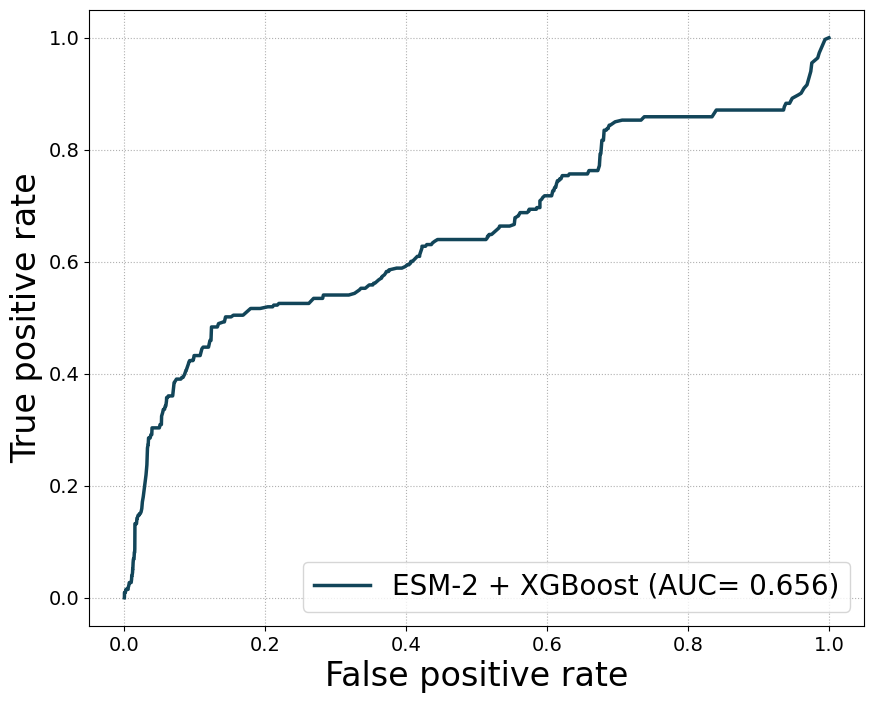

In [23]:
# results, ROC AUC 
labels = np.concatenate(label_list).ravel()
scoreslr = np.concatenate(scores_lan).ravel()

fig, ax = plt.subplots(figsize=(10,8))
os.makedirs('../results/vbeta', exist_ok=True)

fpr, tpr, thrs = roc_curve(labels, scoreslr)
rauclr = round(auc(fpr, tpr), 3)
ax.plot(fpr, tpr, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost (AUC= '+str(rauclr)+')')
ax.set_xlabel('False positive rate', size=24)
ax.set_ylabel('True positive rate', size=24)
ax.legend(loc=4, prop={'size': 20})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.savefig('../results/vbeta/logocv_rocauc.png', dpi=400)
fig.savefig('../results/vbeta/logocv_rocauc_svg.svg', format='svg', dpi=400)

#### Hit ratio against microbiologist approach

In [24]:
# ---- Hit ratio against microbiologist approach (CSV only) ----
import os
import pandas as pd
import numpy as np
import json
import random

data_dir = '../data'

# Real files (CSV)
interactions1_csv = os.path.join(data_dir, 'phage_host_interactions.csv')
interactions2_csv = os.path.join(data_dir, 'klebsiella_interactions_part2.csv')  # optional
locipath = os.path.join(data_dir, 'Locibase.json')
serotypes_csv = os.path.join(data_dir, 'serotypes.csv')

# Loading files
matrix1 = pd.read_csv(interactions1_csv, index_col=0)
matrix2 = pd.read_csv(interactions2_csv, index_col=0) if os.path.exists(interactions2_csv) else None

with open(locipath) as f:
    locibase = json.load(f)
seros = pd.read_csv(serotypes_csv)

# --------------------
# Common preparation
# --------------------
hits = {i: 0 for i in range(1, 51)}
hits2 = {i: 0 for i in range(1, 51)}
total = 0
total2 = 0

# Associate a serotype to each accession (order of seros aligned with Locibase)
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]

# --------------------
# MATRIX 1 (csv)
# --------------------
sorted_phages = matrix1.sum().sort_values(ascending=False).index.tolist()

# Same exclusions as in your original code
no_genome = ['K2', 'K21', 'K23', 'K27', 'K28', 'K40', 'K45', 'K48', 'K52', 'K53', 'K67', 'K69', 'K70', 'K71', 'K72']
rownames = [str(i) for i in list(matrix1.index.values) if i not in no_genome]

# Keep only the keys present in the matrix
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]

for accession in rownames:
    if sum(matrix1.loc[accession]) > 0:
        serotype = loci_serotype[str(accession)]
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype and key != str(accession)]

        # suggestions = columns with 1 for other accessions of same serotype
        phage_suggestions = []
        for acc in same_serotype:
            acc_cast = int(acc) if acc in ['132','779','806','228','245','406','1210','1446','1468','1572','2164'] else acc
            colnames = matrix1.columns[matrix1.loc[acc_cast] == 1].tolist() if acc_cast in matrix1.index else []
            phage_suggestions.append(colnames)

        phage_suggestions = list(set([p for sub in phage_suggestions for p in sub]))
        phage_suggestions.sort(key=lambda x: matrix1[x].sum(), reverse=True)

        total += 1
        for k in range(1, 51):
            if k > len(phage_suggestions):
                # complete with the broadest phages if not enough suggestions
                pool = [s for s in sorted_phages if s not in phage_suggestions]
                phage_suggestions = phage_suggestions + pool[:(k - len(phage_suggestions))]
            if any(matrix1.loc[accession, sugg] == 1 for sugg in phage_suggestions):
                hits[k] += 1

# --------------------
# MATRIX 2 (csv if available)
# --------------------
if matrix2 is not None:
    loci_serotype2 = {}
    for i, accession in enumerate(locibase.keys()):
        loci_serotype2[accession] = seros['sero'][i]

    sorted_phages2 = matrix2.sum().sort_values(ascending=False).index.tolist()

    rownames2 = [str(i) for i in list(matrix2.index.values)]
    for key in list(loci_serotype2.keys()):
        if key not in rownames2:
            del loci_serotype2[key]

    for accession in matrix2.index.values:
        if sum(matrix2.loc[accession]) > 0:
            serotype = loci_serotype2[str(accession)]
            same_serotype = [key for key, value in loci_serotype2.items() if value == serotype and key != str(accession)]

            phage_suggestions = []
            for acc in same_serotype:
                acc_cast = int(acc) if acc in ['132','779','806','228','245','406','1210','1446','1468','1572','2164'] else acc
                colnames = matrix2.columns[matrix2.loc[acc_cast] == 1].tolist() if acc_cast in matrix2.index else []
                phage_suggestions.append(colnames)

            phage_suggestions = list(set([p for sub in phage_suggestions for p in sub]))
            phage_suggestions.sort(key=lambda x: matrix2[x].sum(), reverse=True)

            total += 1
            total2 += 1
            for k in range(1, 51):
                if k > len(phage_suggestions):
                    pool = [s for s in sorted_phages2 if s not in phage_suggestions]
                    phage_suggestions = phage_suggestions + pool[:(k - len(phage_suggestions))]
                if any(matrix2.loc[accession, sugg] == 1 for sugg in phage_suggestions):
                    hits[k] += 1
                    hits2[k] += 1

# Ratios
informed_hitratio  = {k: (hits[k]  / total)  if total  > 0 else np.nan for k in hits}
informed_hitratio2 = {k: (hits2[k] / total2) if total2 > 0 else np.nan for k in hits2}


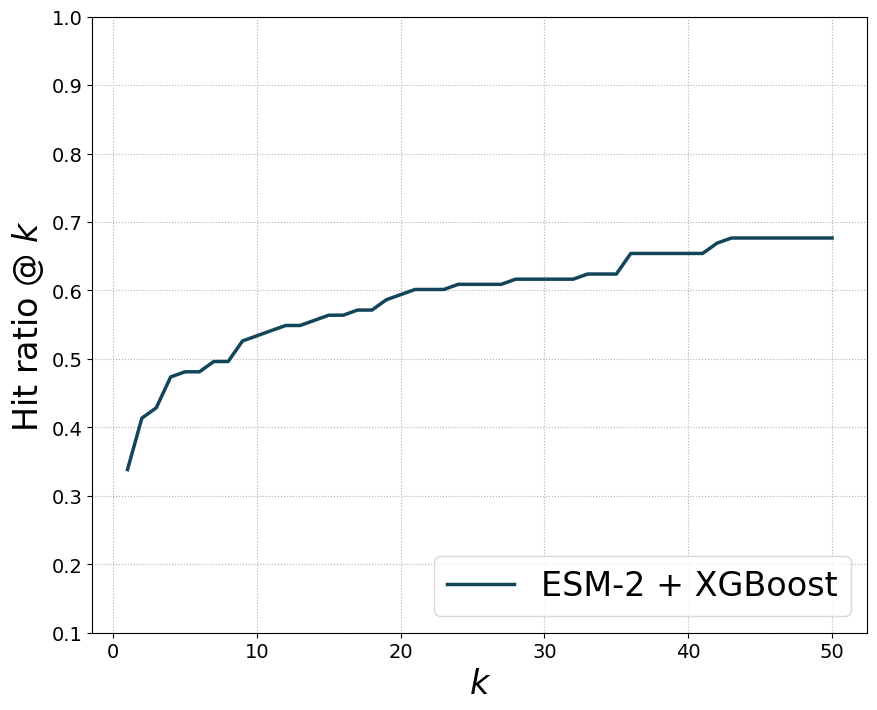

In [25]:
# results, hit ratios @ K
ks = np.linspace(1, 50, 50)
hits_lan = [phlu.hitratio(rqueries_lan, int(k)) for k in ks]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(ks, hits_lan, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost')
ax.set_xlabel('$\it{k}$', size=24)
ax.set_ylabel('Hit ratio @ $\it{k}$', size=24)
ax.set_ylim(0.1, 1)
ax.legend(loc=4, prop={'size': 24})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.savefig('../results/vbeta/logocv_hitratio_informed.png', dpi=400)
fig.savefig('../results/vbeta/logocv_hitratio_informed_svg.svg', format='svg', dpi=400)

#### Performance per K-type

https://medium.com/@curryrowan/simplified-logistic-regression-classification-with-categorical-variables-in-python-1ce50c4b137

In [26]:
threshold_str = '995' 
pickle_path = f"../results/v3.4/combined_logocv_results_v34_{threshold_str}.pickle"
with open(pickle_path, 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
label_list = logo_results['labels']

# read K-types
seros = pd.read_csv('../data/serotypes.csv')

In [ ]:
# mean hit ratio per K-type
unique_seros = list(set(seros['sero']))
performance_ktypes = {}
labelcount_ktypes = {}
for unique in unique_seros:
    indices = seros['sero'] == unique
    subscores_lan = [val for is_good, val in zip(indices, scores_lan) if is_good]
    sublabels = [val for is_good, val in zip(indices, label_list) if is_good]
    labelcount_ktypes[unique] = [sum(i) for i in sublabels]
    rqueries_lan = []
    for i in range(len(subscores_lan)):
        score_lan = subscores_lan[i]
        y_test = sublabels[i]
        if sum(y_test) > 0:
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
    if len(rqueries_lan) > 0:
        hr_lan = round(phlu.hitratio(rqueries_lan, 10), 3)
        performance_ktypes[unique] = [('HR_XGB', hr_lan)]

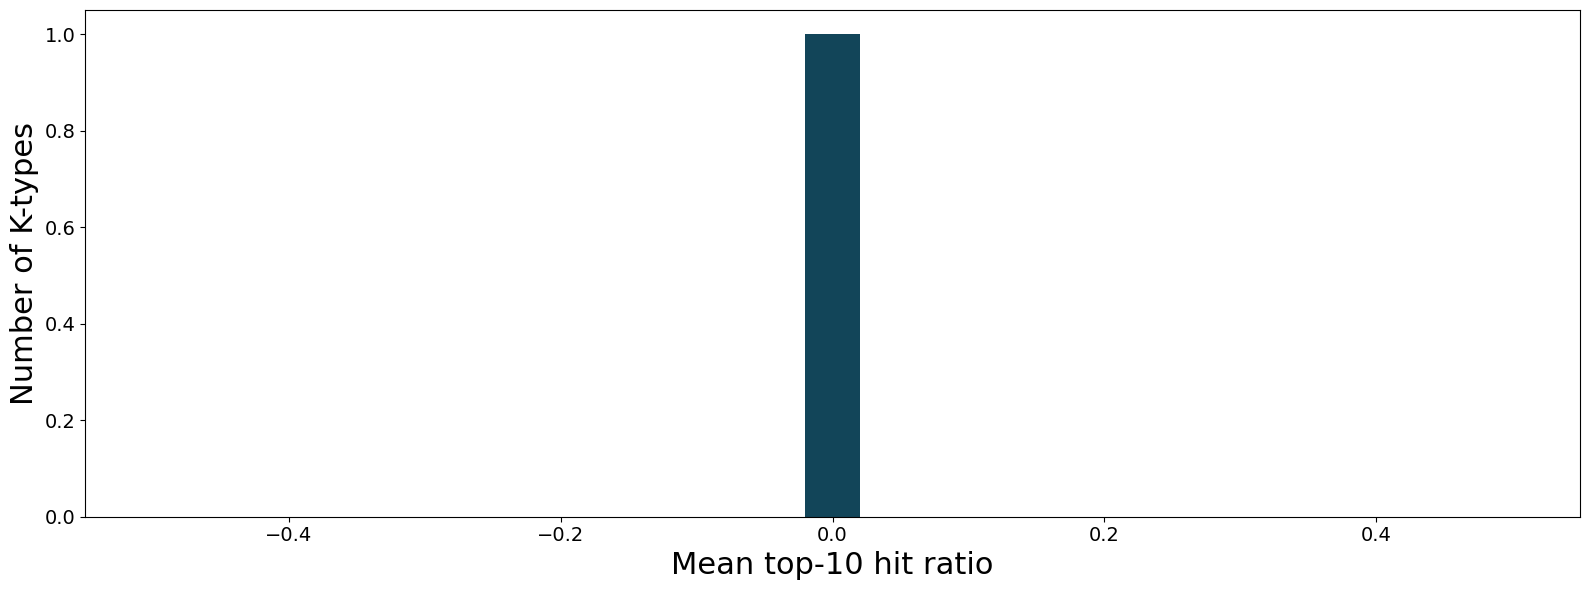

In [28]:
performance_hr_xgb = []
for ktype in performance_ktypes:
    performance_hr_xgb.append(performance_ktypes[ktype][0][1])
sortedpairs = [(x,y) for y, x in sorted(zip(performance_hr_xgb, list(performance_ktypes.keys())), reverse=True)]
fig, ax = plt.subplots(figsize=(16,6))
ax.hist(performance_hr_xgb, bins=25, color='#124559')
#sns.barplot(x=[score for (key, score) in sortedpairs], y=[key for (key, score) in sortedpairs], ax=ax, palette='magma')
ax.set_xlabel('Mean top-10 hit ratio', size=22)
ax.set_ylabel('Number of K-types', size=22)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.tight_layout()
fig.savefig('../results/vbeta/histogram_ktypes_svg.svg', format='svg', dpi=400)

#### Hit ratio per K-type versus number of pos labels

In [29]:
top10 = [x[0] for x in sortedpairs if x[1] == 1] # all with HR == 1
bottom10 = [x[0] for x in sortedpairs if x[1] == 0] # all with HR == 0
middle = [x[0] for x in sortedpairs if (x[1] != 0 and x[1] != 1)]
countst10 = []
countsb10 = []
countsmid = []
for key in labelcount_ktypes.keys():
    if key in top10:
        countst10.append(labelcount_ktypes[key])
    elif key in bottom10:
        countsb10.append(labelcount_ktypes[key])
    elif key in middle:
        countsmid.append(labelcount_ktypes[key])
countst10 = [i for x in countst10 for i in x]
countsb10 = [i for x in countsb10 for i in x]
countsmid = [i for x in countsmid for i in x]

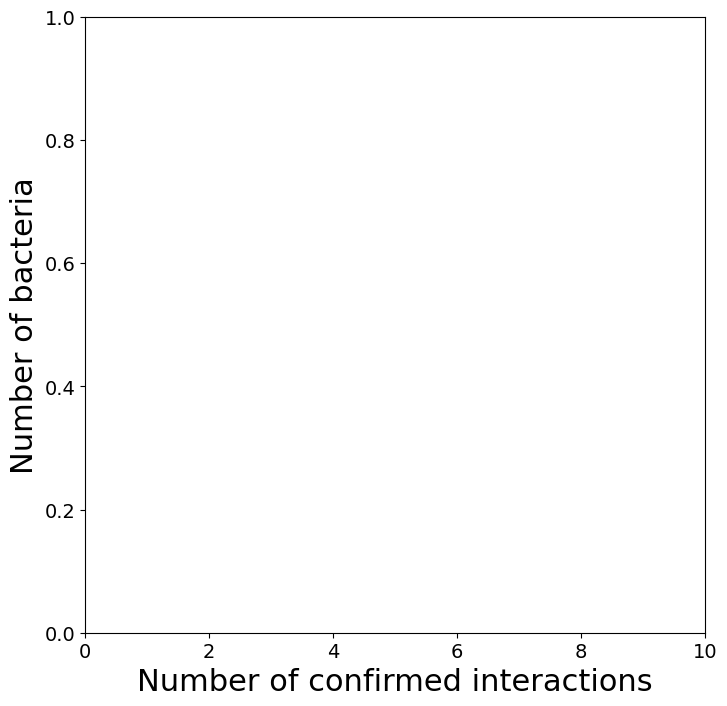

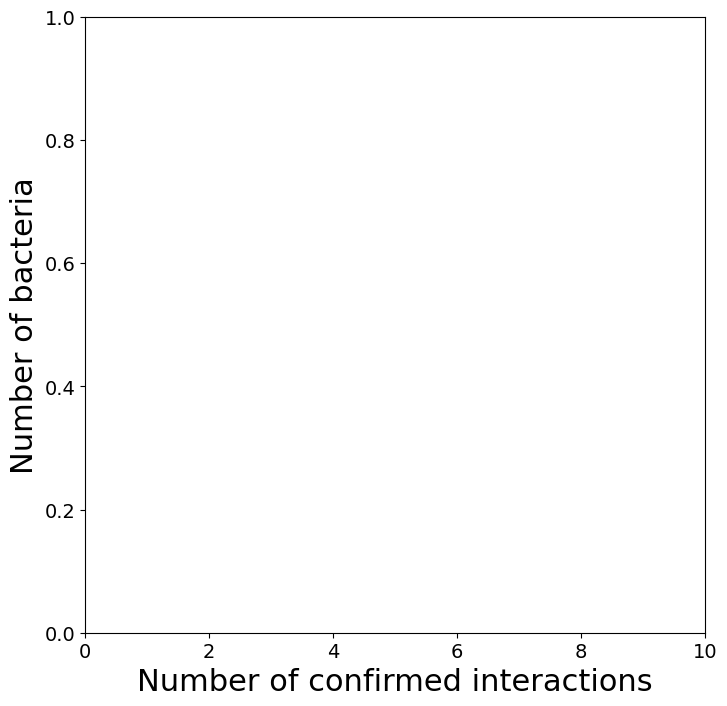

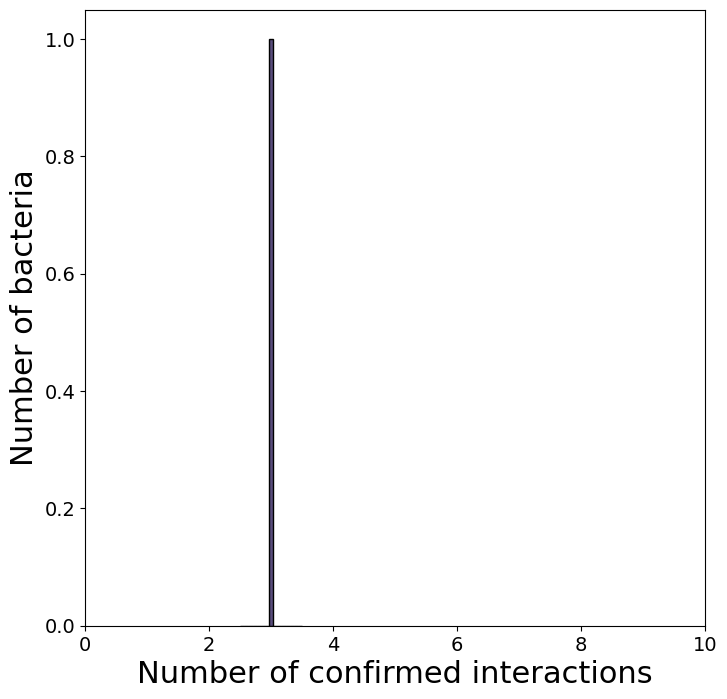

In [30]:
countlist = [countst10, countsmid, countsb10]
binlist = [15, 15, 15]

for i, count in enumerate(countlist):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(count, ax=ax, color='#221150', bins=binlist[i])
    ax.set_xlim(0, 10)
    ax.set_xlabel('Number of confirmed interactions', size=22)
    ax.set_ylabel('Number of bacteria', size=22)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.xaxis.set_tick_params(labelsize = 14)
    fig.savefig('../results/v3.4/ktypecounts_svg'+str(i)+'.svg', format='svg', dpi=400)